In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
import re
from docx import Document
import pandas as pd
import os
from glob import glob

In [ ]:
# This code will skip the summaries

def parse_document(text):
    articles = text.split('End of Document')
    data = []
    for article in articles[:-1]:  # Skip the last split as it would be empty
        title_search = re.search(r'(.+)\n(.+)\n(.+)', article)
        title = title_search.group(1).strip() if title_search else None
        newspaper = title_search.group(2).strip() if title_search else None
        date = title_search.group(3).strip() if title_search else None

        location_search = re.search(r'(Section|Dateline):\s*(.+)', article)
        location = location_search.group(2).strip() if location_search else 'Not Available'

        body_search = re.search(r'Body\s*(.+)', article, re.DOTALL)
        body = body_search.group(1).strip() if body_search else None

        if title and newspaper and date and body:  # Add only if all parts are found
            data.append({
                'Title': title,
                'Newspaper': newspaper,
                'Date': date,
                'Section': location,
                'Body': body
            })
    return pd.DataFrame(data)

def extract_text_from_docx(docx_path):
    doc = Document(docx_path)
    full_text = '\n'.join([paragraph.text for paragraph in doc.paragraphs if paragraph.text])

    # Delete the specific lines starting with "User Name", "Date and Time", and "Job Number"
    pattern = re.compile(r'User Name:.*\nDate and Time:.*\nJob Number:.*\nDocuments.*\n')
    full_text = re.sub(pattern, '', full_text)

    return full_text

def process_all_docx(folder_path):
    docx_files = glob(os.path.join(folder_path, '*.DOCX'))
    all_data = []

    for file_path in docx_files:
        text = extract_text_from_docx(file_path)
        df = parse_document(text)
        all_data.append(df)

    return pd.concat(all_data, ignore_index=True)

# Example usage:
# folder_path = 'path/to/your/docx/files'
# final_df = process_all_docx(folder_path)


In [ ]:
# Replace 'your/folder/path' with the actual folder path containing your .docx files
#folder_path = 'your/folder/path'
df_processed = process_all_docx('/content/drive/MyDrive/raw_articles')
df = df_processed.drop_duplicates(subset=['Body'])
if not df.empty:
    # Print the DataFrame to check
    print(df.head())

    # Save the DataFrame to a CSV file
    df.to_csv('/content/drive/MyDrive/dataset/news_articles.csv', index=False)
else:
    print("No articles were extracted. Please check the format of your documents.")


                                               Title  \
0  1. Kanpur to be one of the most polluted citie...   
1                           Ghaziabad raises a stink   
2            Pune's task on hand is to clear the air   
3          Emission inventory for city getting ready   
4  Road dust, vehicular exhaust contribute to PM1...   

                  Newspaper                                  Date    Section  \
0     Client/Matter: -None-  Search Terms: Air Pollution in India     KANPUR   
1  The Times of India (TOI)                 June 5, 2010 Saturday  POLLUTION   
2  The Times of India (TOI)                July 31, 2010 Saturday       PUNE   
3  The Times of India (TOI)               August 10, 2010 Tuesday       PUNE   
4  The Times of India (TOI)               August 10, 2010 Tuesday       PUNE   

                                                Body  
0  KANPUR: "There are nearly 65 cities and towns ...  
1  Its proximity to the Capital might have actual...  
2  PUNE: Air poll

In [ ]:
# Specify the format for parsing dates
date_format = "%B %d, %Y %A"

# Function to parse date or return NaT for nonsensical values
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format=date_format)
    except ValueError:
        return pd.NaT

# Apply the function to the 'Date' column
df['Date'] = df['Date'].apply(parse_date)

# Remove rows with NaT values (nonsensical dates)
#df = df.dropna(subset=['Date'])

<ipython-input-6-e9690a9a095b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(parse_date)


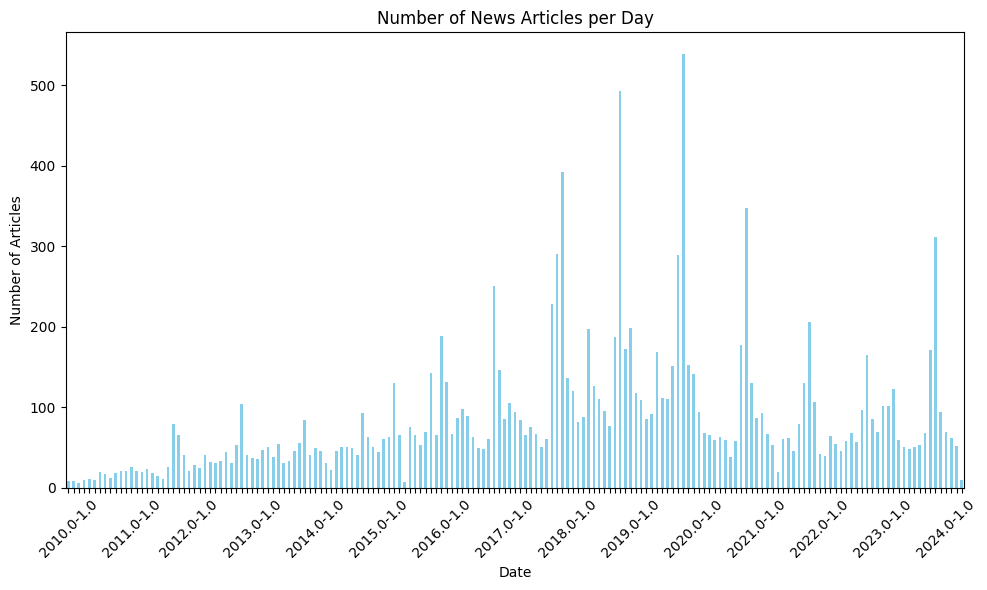

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df contains your DataFrame with the 'Date' column already converted to datetime objects

# Group by year and month, and count the number of articles in each group
articles_per_month = df.groupby([df['Date'].dt.year, df['Date'].dt.month]).size()

# Plot the data
plt.figure(figsize=(10, 6))
articles_per_month.plot(kind='bar', color='skyblue')

# Set x-axis ticks to be labeled by years only
plt.xticks(range(len(articles_per_month.index)), [f"{year}-{month}" if month == 1 else "" for year, month in articles_per_month.index], rotation=45)

plt.title('Number of News Articles per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()


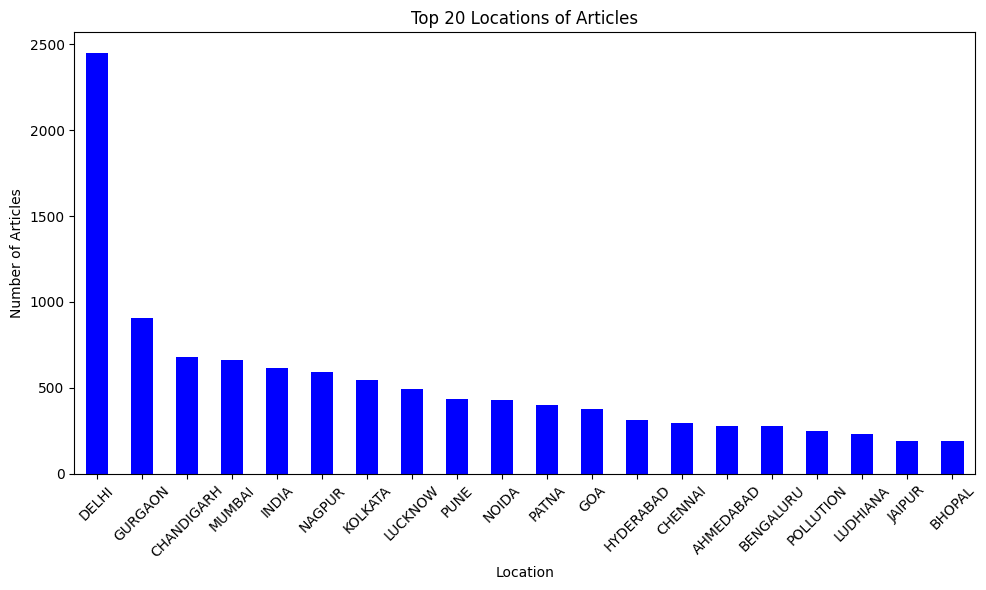

In [ ]:
# Group by section, usually has the name of the place in there
articles_per_section = df.groupby(df['Section']).size()

# Sort the data in descending order and select the top 10 locations
top_10_locations = articles_per_section.sort_values(ascending=False).head(20)

# Plot the data
plt.figure(figsize=(10, 6))
top_10_locations.plot(kind='bar', color='blue')
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.title('Top 20 Locations of Articles')
plt.xlabel('Location')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

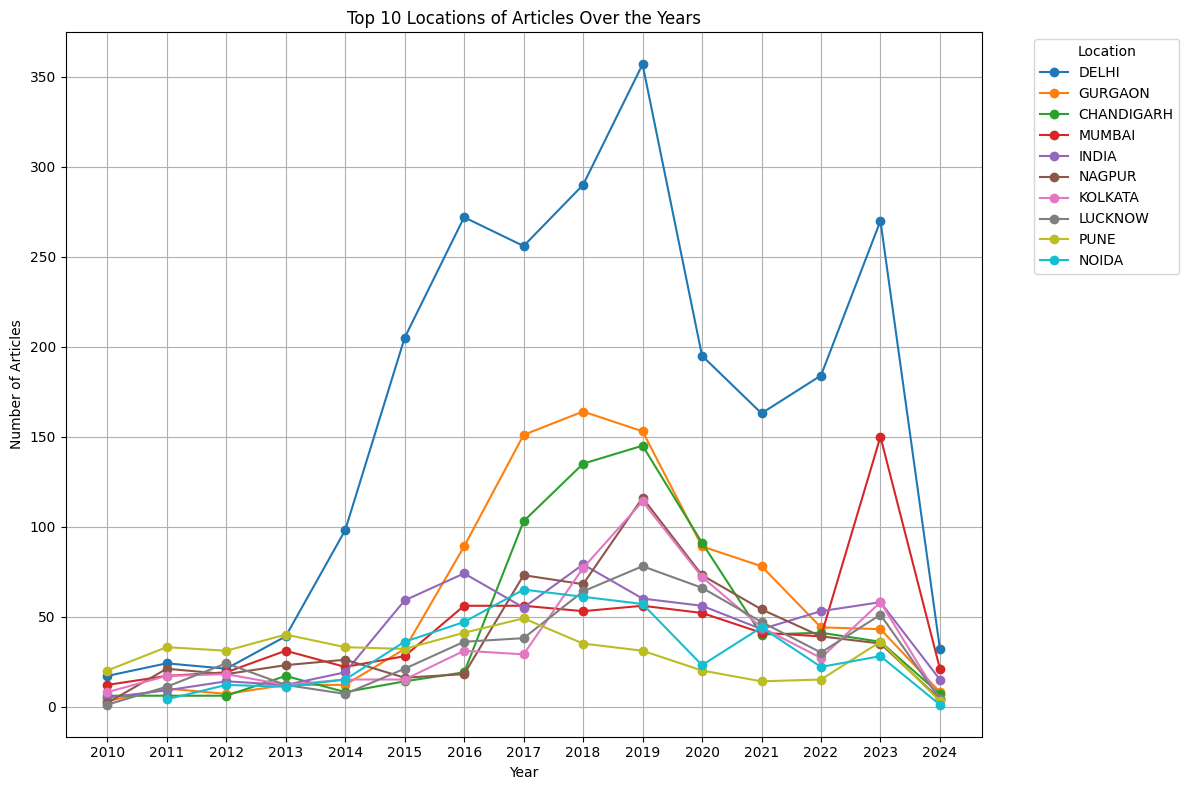

In [ ]:
# Group by year and section to count the number of articles per location per year
articles_per_year_per_section = df.groupby(['Year', 'Section']).size().reset_index(name='Count')

# Get the top 10 locations based on total number of articles
top_10_locations = articles_per_year_per_section.groupby('Section')['Count'].sum().nlargest(10).index

# Plot the data for each top 10 location
plt.figure(figsize=(12, 8))

for location in top_10_locations:
    location_data = articles_per_year_per_section[articles_per_year_per_section['Section'] == location]
    plt.plot(location_data['Year'], location_data['Count'], marker='o')

plt.title('Top 10 Locations of Articles Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Articles')

# Set x ticks to every year from 2010 to 2024
plt.xticks(range(2010, 2025))

plt.legend(top_10_locations, title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

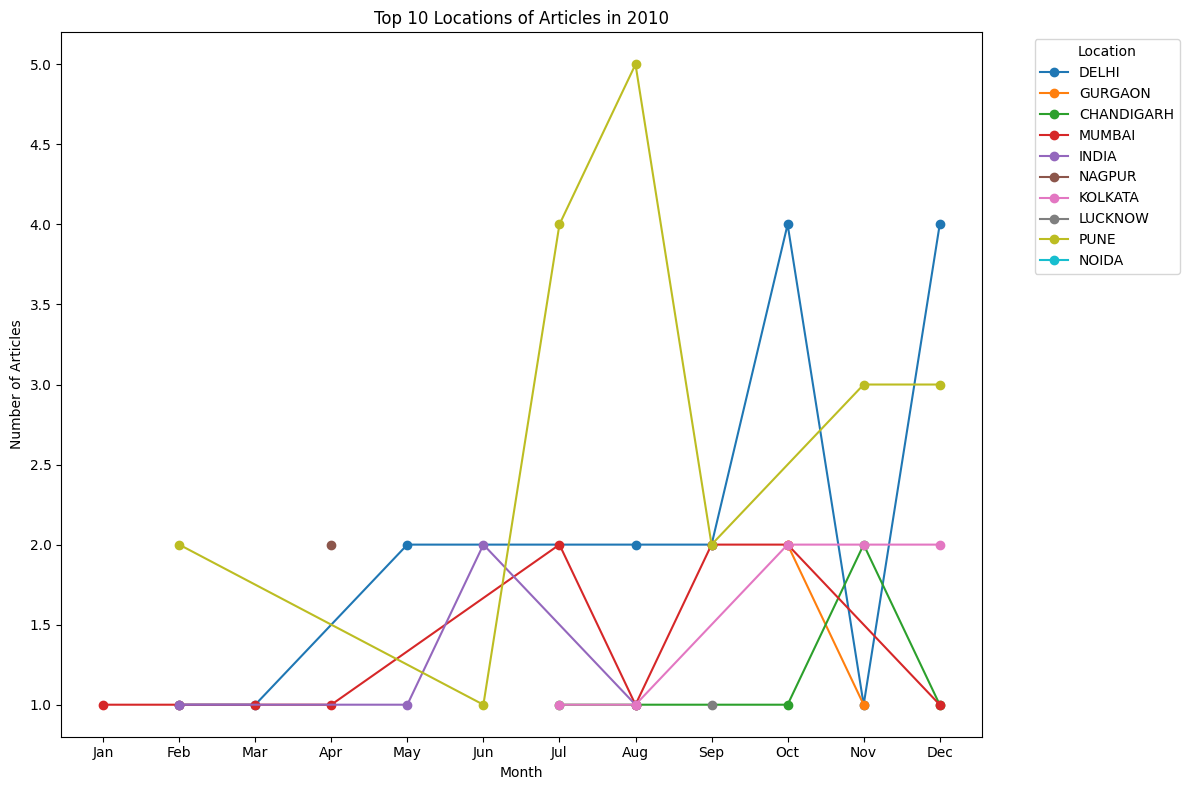

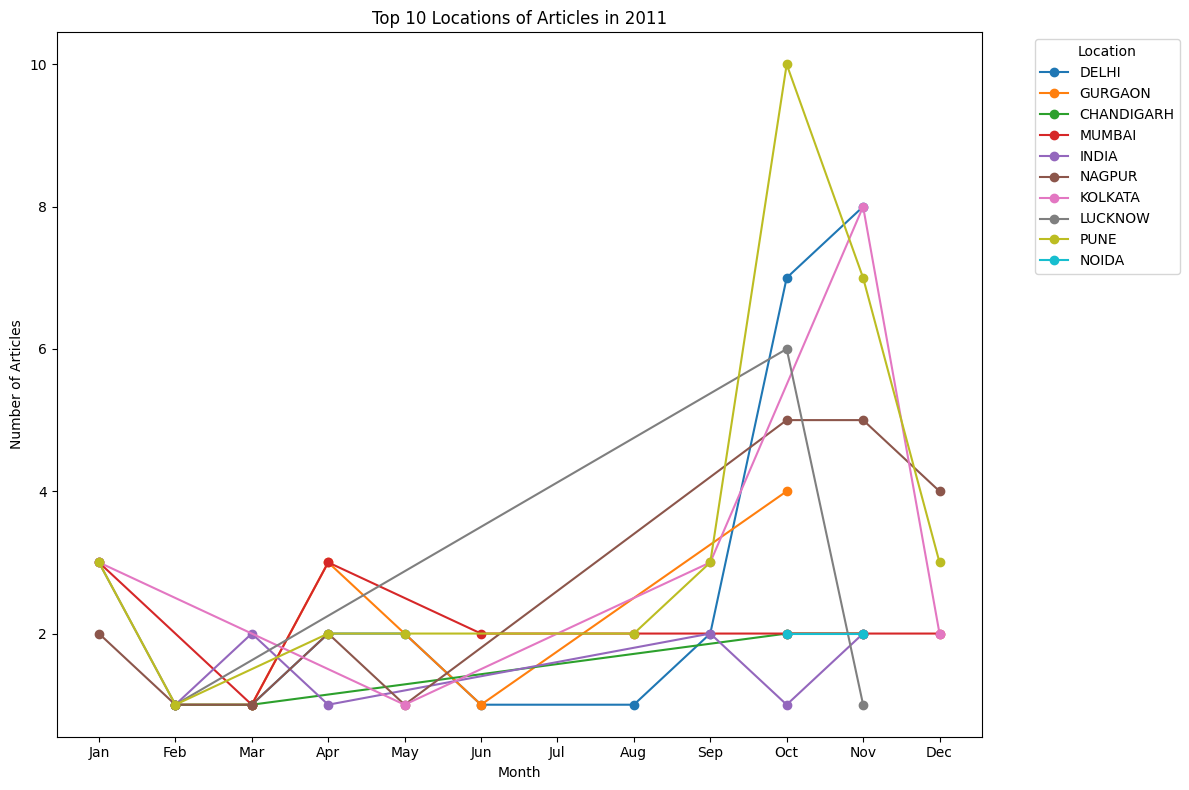

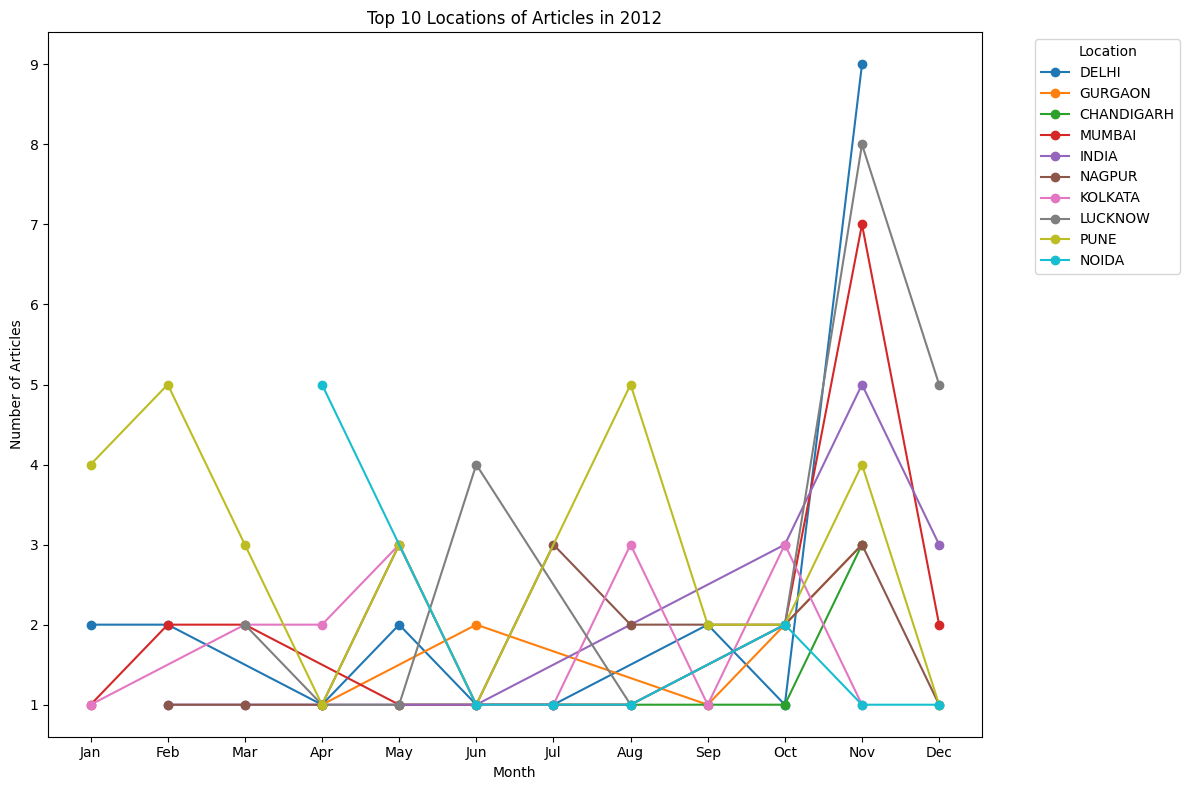

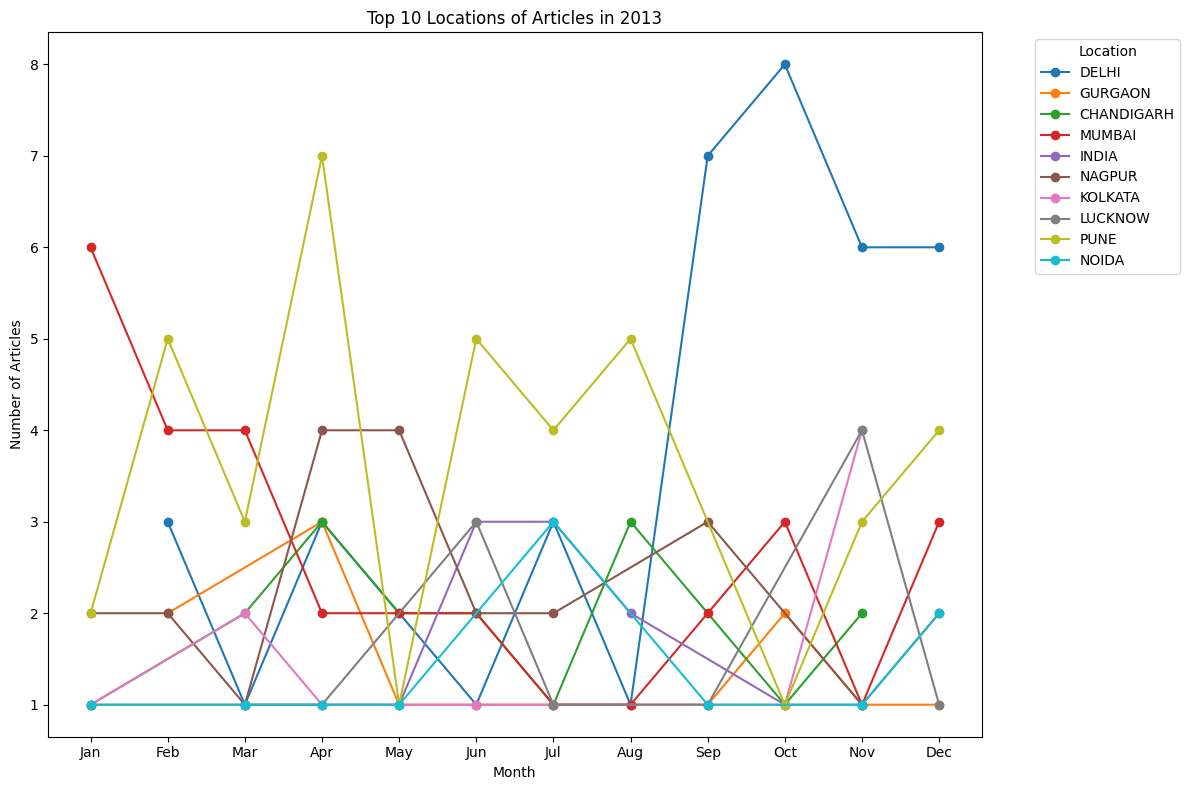

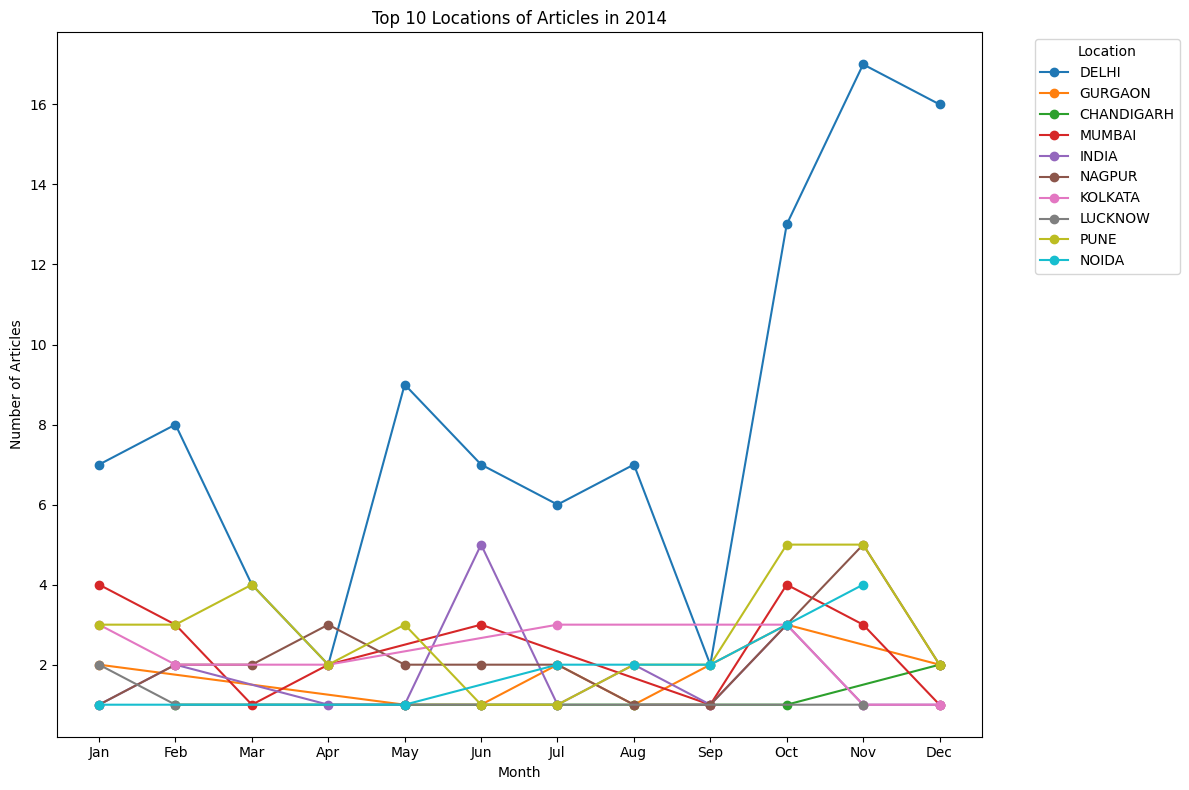

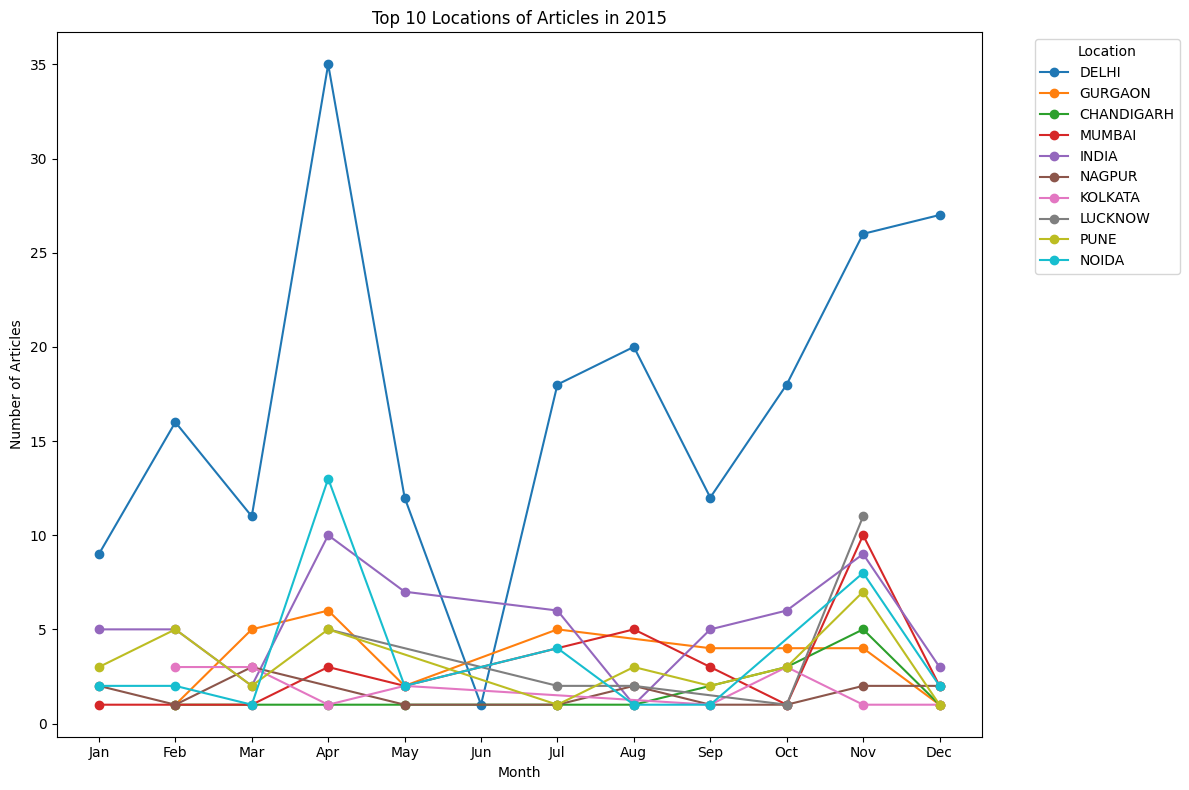

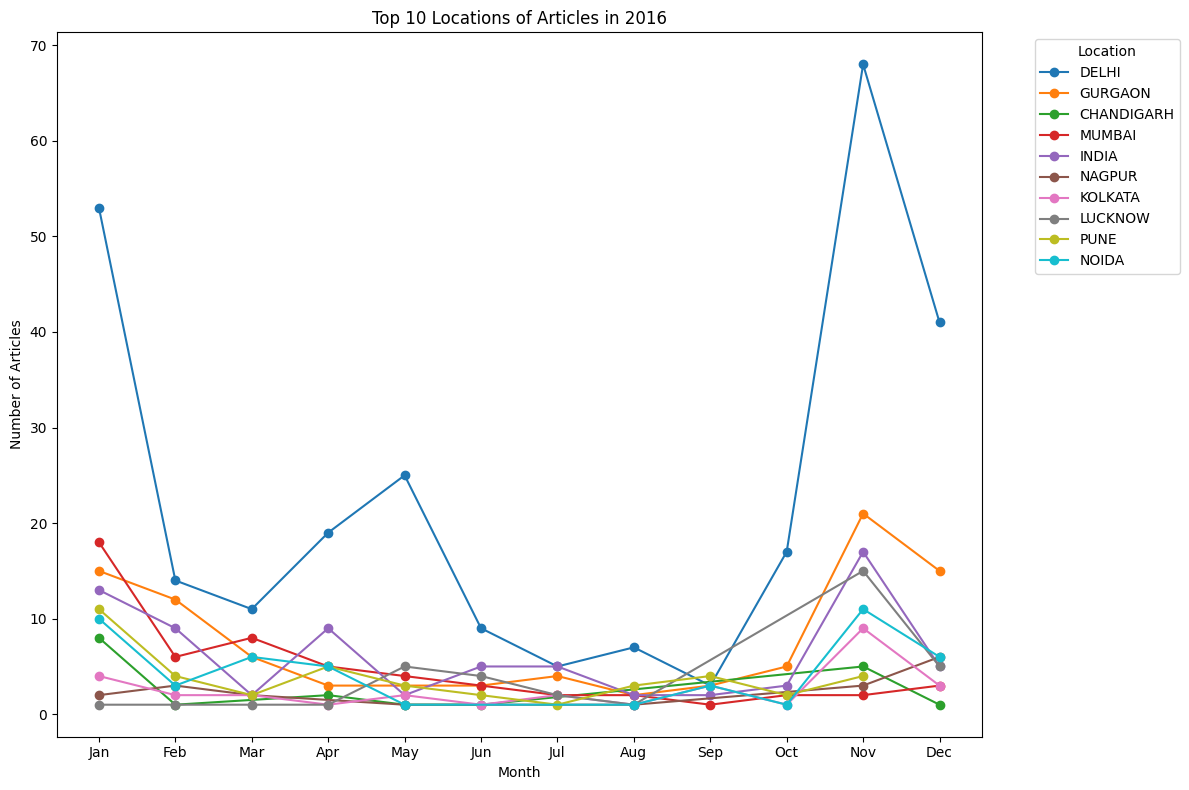

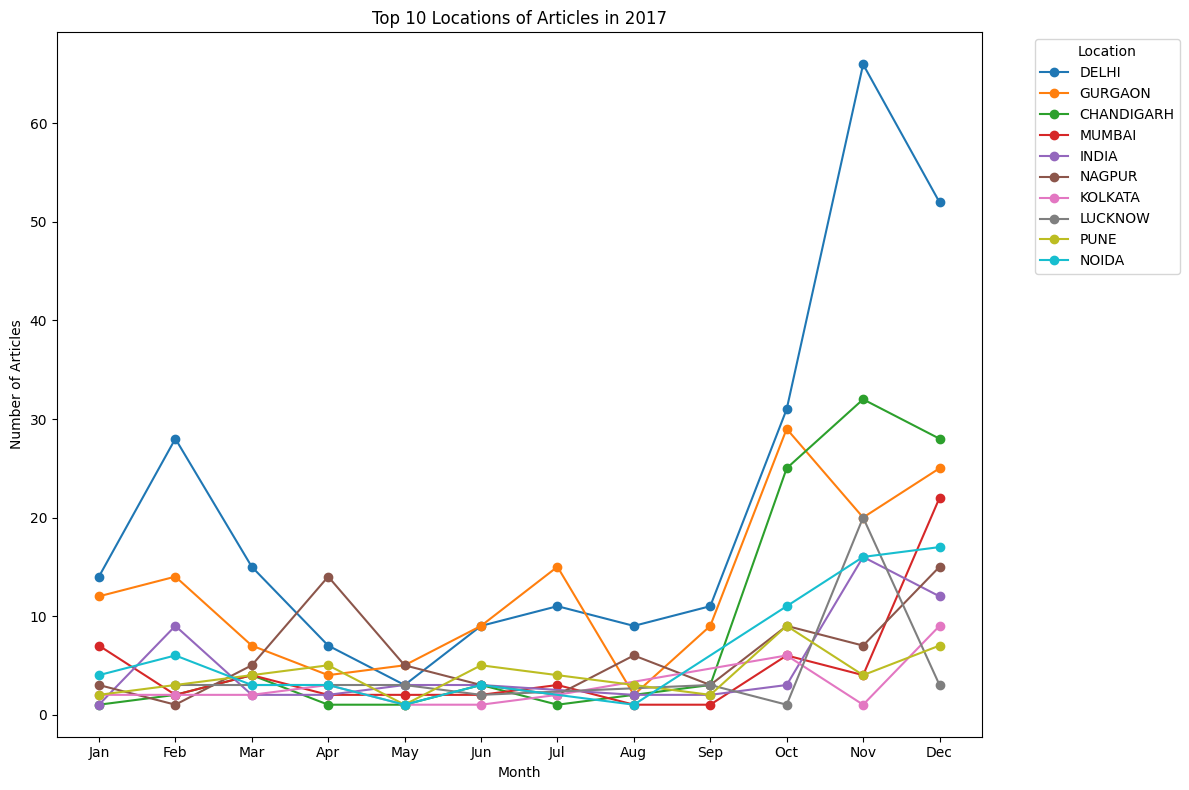

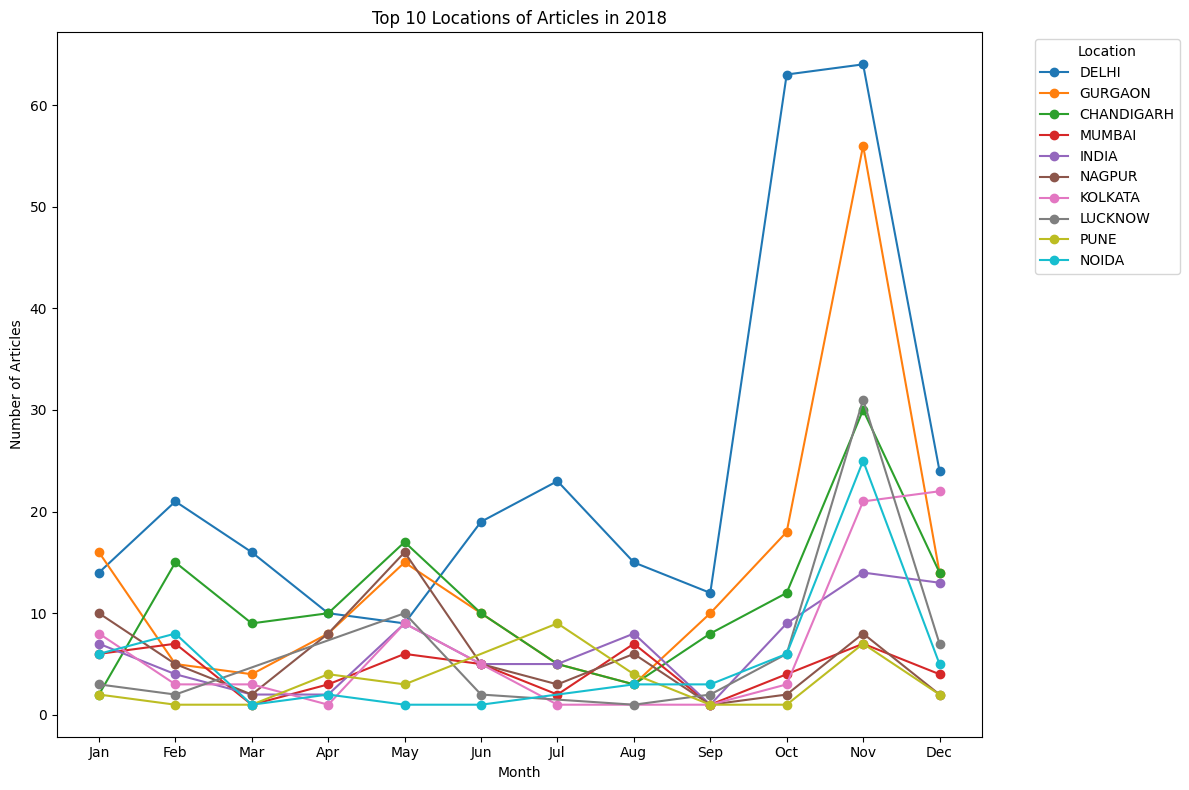

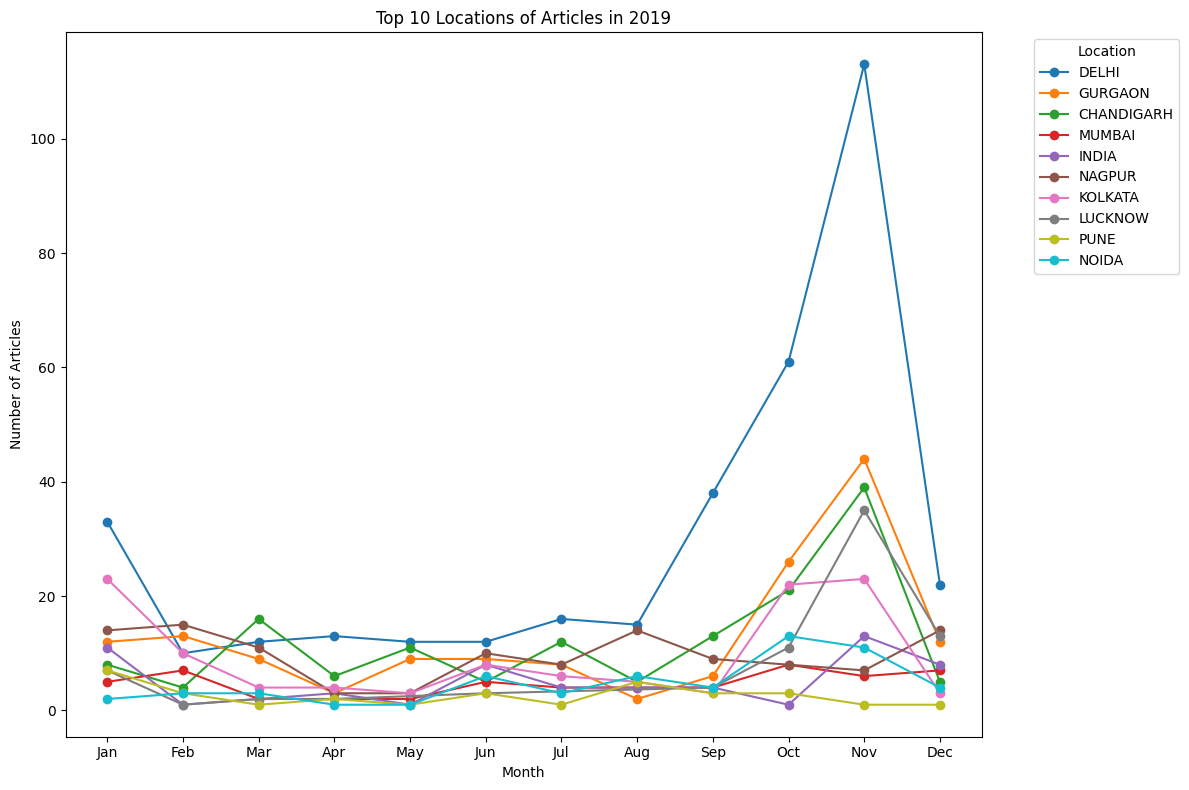

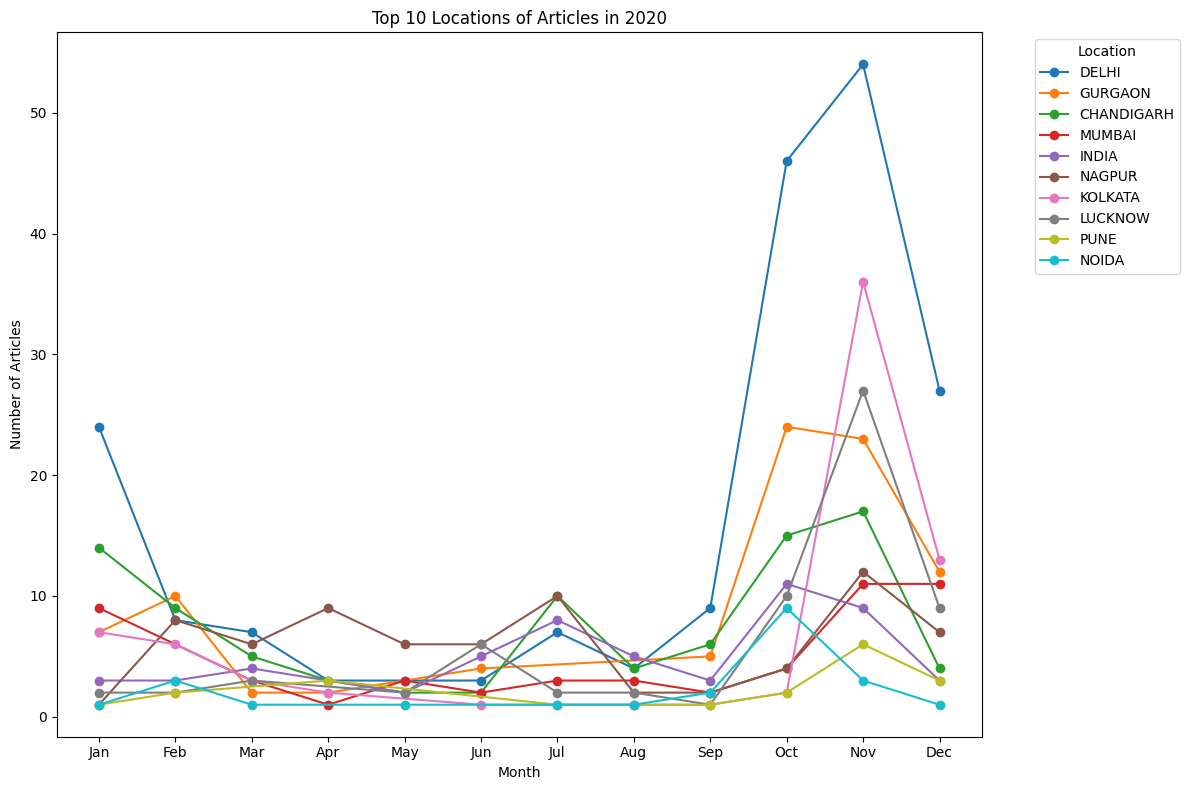

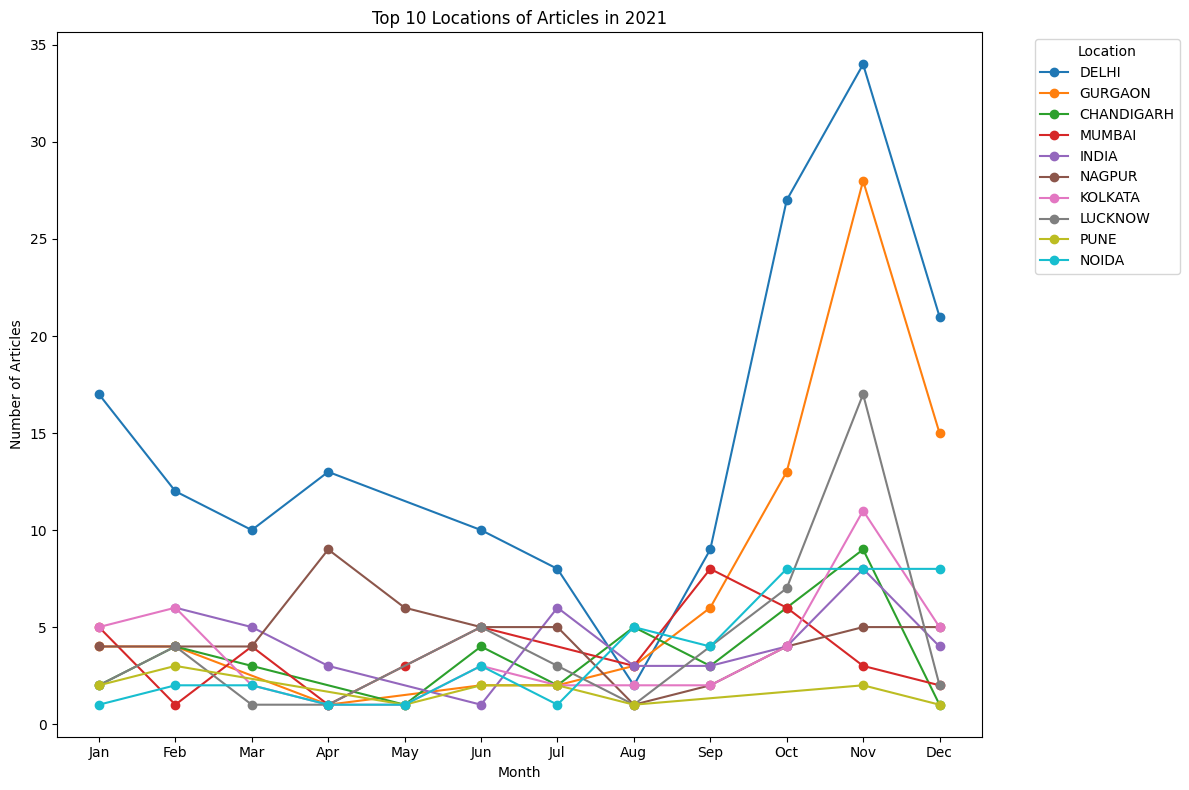

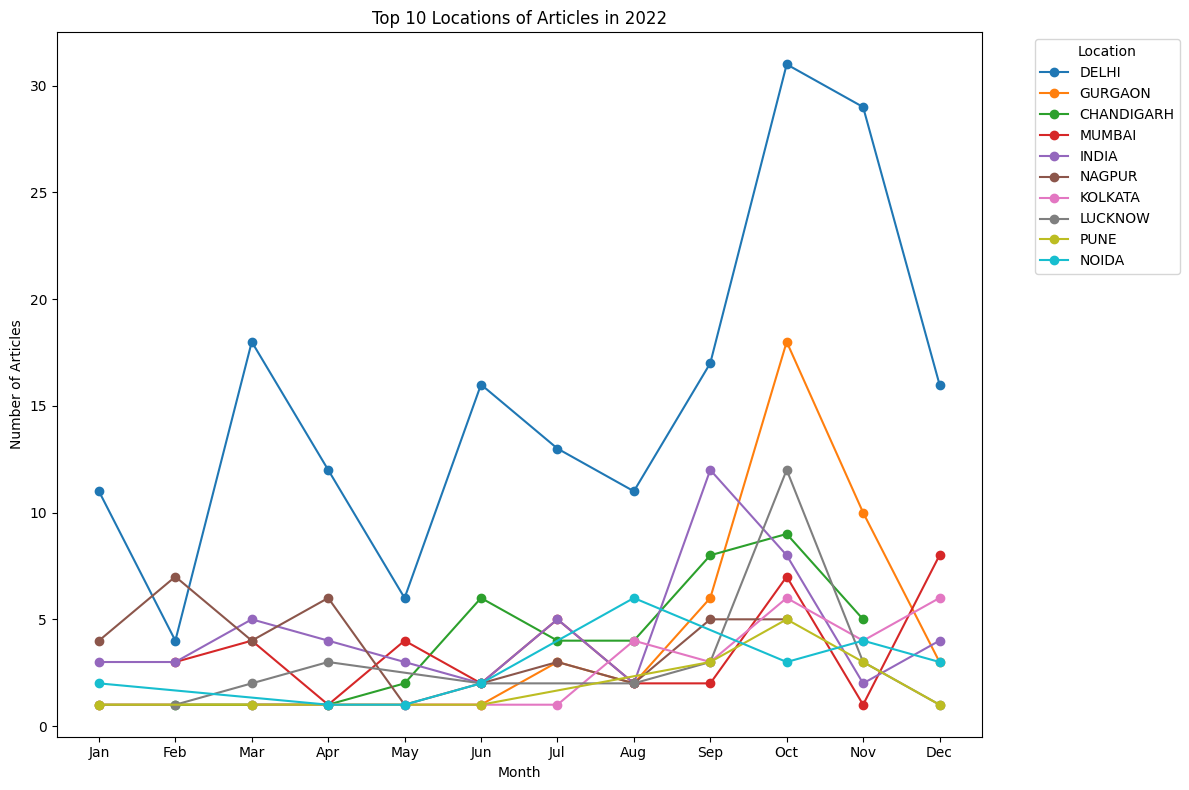

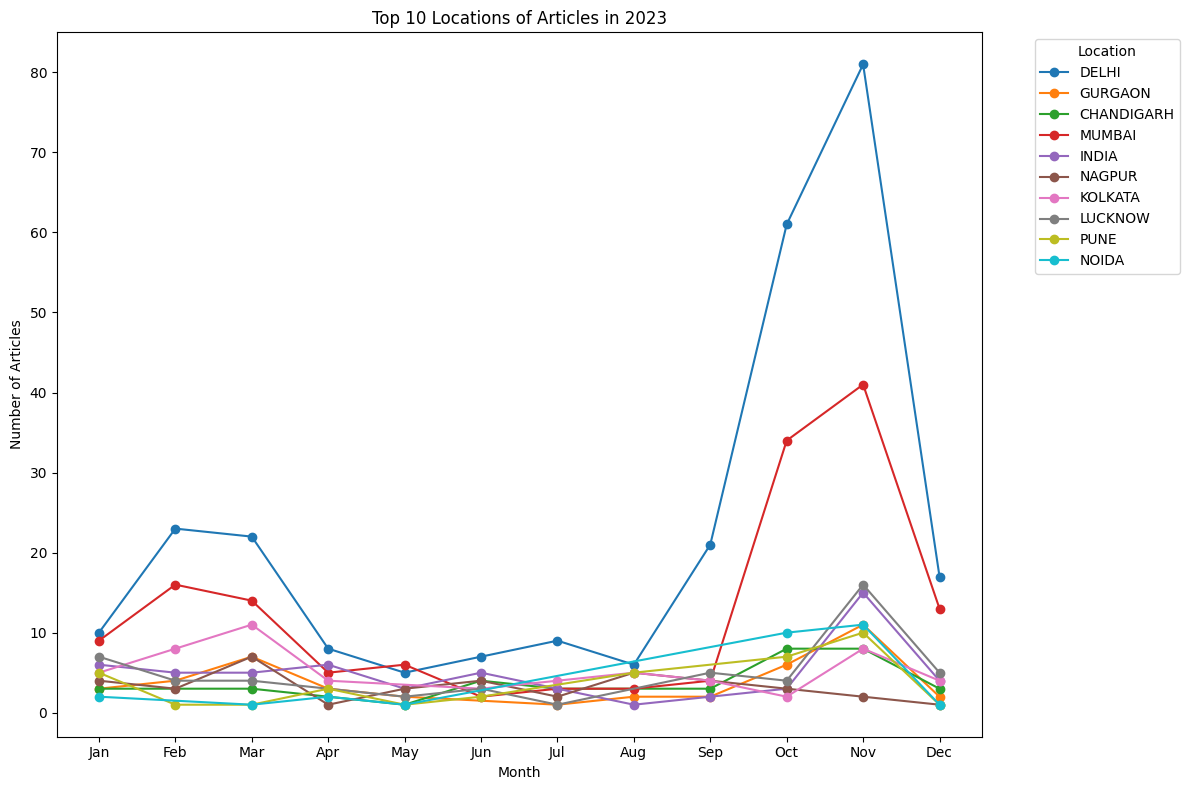

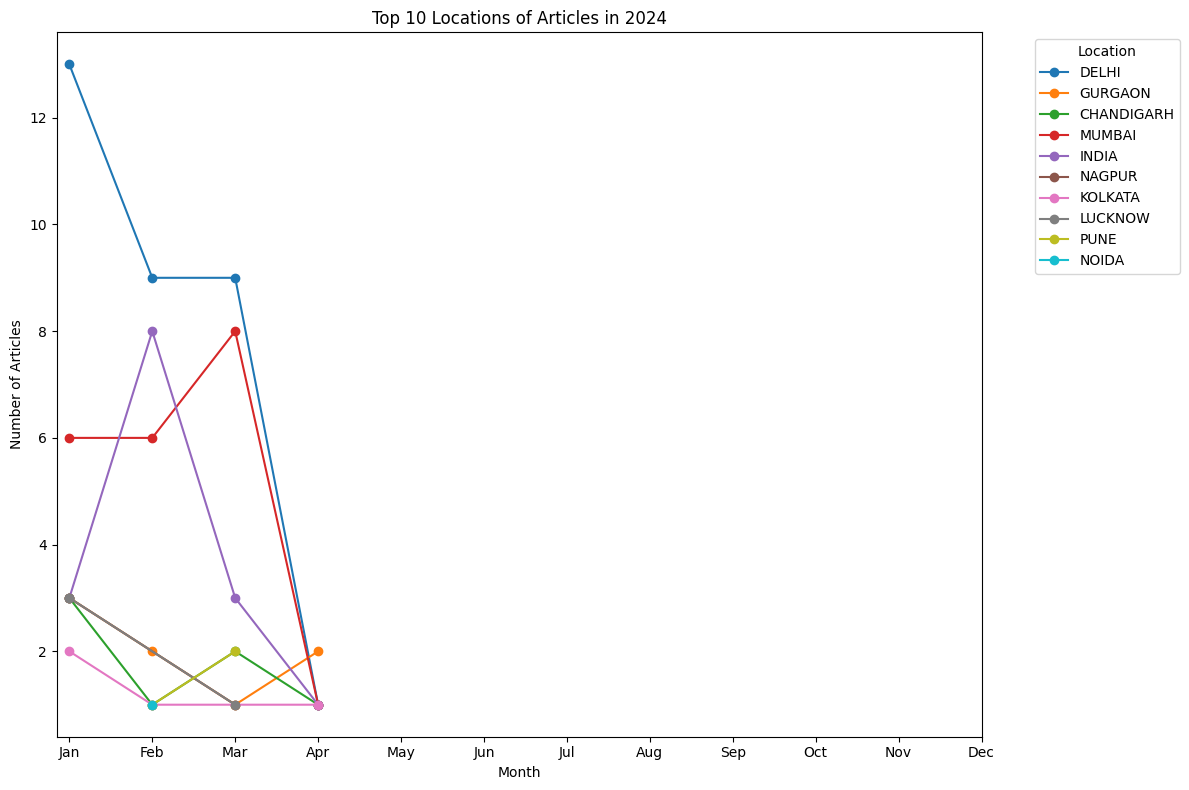

In [ ]:
# Get the range of years from the 'Year' column
years = df['Year'].unique()

# Group by year, month, and section to count the number of articles per location per month
articles_per_year_month_section = df.groupby(['Year', 'Month', 'Section']).size().reset_index(name='Count')

# Get the top 10 locations based on total number of articles
top_10_locations = articles_per_year_month_section.groupby('Section')['Count'].sum().nlargest(10).index

# Plot the data for each top 10 location for each year
for year in sorted(years):
    if pd.isnull(year):
        continue  # Skip NaN years

    plt.figure(figsize=(12, 8))
    for location in top_10_locations:
        location_data = articles_per_year_month_section[(articles_per_year_month_section['Year'] == year) & (articles_per_year_month_section['Section'] == location)]
        plt.plot(location_data['Month'], location_data['Count'], marker='o', label=location)

    plt.title(f'Top 10 Locations of Articles in {int(year)}')
    plt.xlabel('Month')
    plt.ylabel('Number of Articles')

    # Set x ticks to every month
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/dataset/news_articles.csv')

In [ ]:
# Specify the format for parsing dates
date_format = "%B %d, %Y %A"

# Function to parse date or return NaT for nonsensical values
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format=date_format)
    except ValueError:
        return pd.NaT

# Apply the function to the 'Date' column
df['Date'] = df['Date'].apply(parse_date)

In [ ]:
# Assuming df contains your DataFrame with the 'Date' column already converted to datetime objects

# Extract year and month from 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group by year and month, and count the number of articles in each group
article_counts = df.groupby(['Year', 'Month']).size()

# Calculate proportions for each group
proportions = article_counts / article_counts.sum()

# Calculate the number of articles to sample from each group
sample_sizes = (proportions * 310).round().astype(int)

# Initialize an empty DataFrame with the same columns as the original DataFrame
sample_df = pd.DataFrame(columns=df.columns)

# Iterate over each group, take a random sample, and append to the sample DataFrame
for (year, month), size in sample_sizes.items():
    group_df = df[(df['Year'] == year) & (df['Month'] == month)]
    sample_df = pd.concat([sample_df, group_df.sample(n=size, random_state=42)])

# Reset index of the sample DataFrame
sample_df.reset_index(drop=True, inplace=True)

sample_df.to_csv('/content/drive/MyDrive/dataset/sample_news_articles.csv', index=False)